In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Project III

/content/drive/MyDrive/Project III


In [3]:
cd transformers

/content/drive/MyDrive/Project III/transformers


In [4]:
! pip3 install --upgrade .

Processing /content/drive/MyDrive/Project III/transformers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.14.0.dev0-py3-none-any.whl size=3321568 sha256=56bdf535995e85b17e9c356c76526ed7b602641bb21a146c930f46016bb675e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-8tqwgh5p/wheels/95/2f/f0/013f5744b7d693b896b4ad11d2922b4392513443e3151ab3ee
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.14.0.d

In [5]:
cd ..

/content/drive/MyDrive/Project III


In [6]:
import re
import time

import numpy as np
from scipy.special import softmax
import unicodedata

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.data import Dataset
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.train import Checkpoint, CheckpointManager
from transformers import TFAutoModel, AutoTokenizer

from sklearn.metrics import f1_score, accuracy_score, classification_report

In [7]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
phobert = TFAutoModel.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [8]:
aspect2id = {
    'RESTAURANT': 0,
    'FOOD': 1,
    'DRINKS': 2,
    'LOCATION': 3,
    'AMBIENCE': 4,
    'SERVICE': 5,
}

In [9]:
def get_vocab(file):
    word2id = {}
    r = open(file, 'r', encoding='utf-8')
    count = 1
    for word in r.read().split('\n'):
        word2id[word] = count
        count += 1
    r.close()
    return word2id

word2id = get_vocab('wordset/restaurant_vocab.txt')

In [10]:
num_aspects = len(aspect2id)

In [11]:
def get_seed(file):
    seed_set = {}
    r = open(file, 'r', encoding='utf-8')
    seeds = r.read().split('\n')[0:-1]
    for i in range(len(seeds)):
        seeds[i] = seeds[i].split('|')[:-1]
        seed_tokens = []
        for seed in seeds[i]:
            if seed in word2id:
                seed_tokens.append(word2id[seed])
            else:
                seed_tokens.append(-1)
        seed_set[i] = seed_tokens
    r.close()
    return seed_set

seed_set = get_seed('wordset/restaurant_seeds.txt')

In [12]:
def get_train_tokens(file):
    r = open(file, 'r', encoding='utf-8')
    docs = r.readlines()
    toks = []
    for i in range(len(docs)):
        docs[i] = docs[i].split()
        tok = [word2id[word] for word in docs[i]]
        toks.append(tok)
    r.close()
    return toks

train_tokens = get_train_tokens('processed/restaurant_train.txt')

In [13]:
def get_train_inp(file):
    r = open(file, 'r', encoding='utf-8')
    docs = r.read().split('\n')[:-1]
    r.close()

    inps = [tokenizer.encode(line) for line in docs]
    return inps
train_inp = get_train_inp('processed/restaurant_train.txt')

Token indices sequence length is longer than the specified maximum sequence length for this model (297 > 256). Running this sequence through the model will result in indexing errors


In [14]:
def get_test(file):
    r = open(file, 'r', encoding='utf-8')
    lines = r.readlines()
    toks = []
    inps = []
    outs = []
    for line in lines:
        sent = line.split('|')[0]
        tok = []
        tok = [word2id[word] for word in sent.split() if word in word2id]
        toks.append(tok)

        sent = line.split('|')[0]
        inp = tokenizer.encode(line)
        inps.append(inp)
        
        #print(line)
        aspect = line.split('|')[1][:-1]
        label = aspect2id[aspect]
        out = [0 for i in range(num_aspects)]
        out[label] = 1
        outs.append(out)
    
    r.close()
    return toks, inps, np.array(outs)

dev_tokens, dev_inp, dev_out = get_test('processed/restaurant_dev.txt')
test_tokens, test_inp, test_out = get_test('processed/restaurant_test.txt')

In [15]:
def get_weight_seed(inps, preds, seed_set):
    weight_seed = {}
    for label in seed_set:
        for seed in seed_set[label]:
            weight_seed[seed] = np.zeros(num_aspects)
    
    for i in range(inps.shape[0]):
        for label in seed_set:
            for seed in seed_set[label]:
                if seed in inps[i]:
                    weight_seed[seed][preds[i]] += 1

    for label in seed_set:
        for seed in seed_set[label]:
            sum = np.sum(weight_seed[seed])
            if sum != 0:
                weight_seed[seed] /= sum    
    
    return weight_seed

In [16]:
default_weight_seed = {}

for label in seed_set:
    for seed in seed_set[label]:
        default_weight_seed[seed] = np.ones(num_aspects)
        # default_weight_seed[seed] /= np.sum(default_weight_seed[seed]) 

In [17]:
def get_train_weak_out(inps, seed_set, weight_seed=default_weight_seed):
    outs = []
    for inp in inps:
        out = []
        cnt = 0
        for label in seed_set:
            bow = 0
            for seed in seed_set[label]:
                bow += np.count_nonzero(inp == seed) * weight_seed[seed][label]
            if bow == 0:
                cnt += 1
            out.append(bow)
    
        if cnt == len(seed_set):
            out[0] = 10000000
        outs.append(out)

    outs = softmax(outs, axis=1)
    return outs

# Visualize data

In [18]:
from collections import Counter
import matplotlib.pyplot as plt

<BarContainer object of 151 artists>

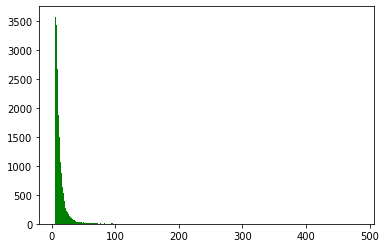

In [19]:
len_train_inp = [len(inp) for inp in train_inp]
len_train_inp = Counter(len_train_inp)
plt.bar(len_train_inp.keys(), len_train_inp.values(), width=1, color='g')

<BarContainer object of 53 artists>

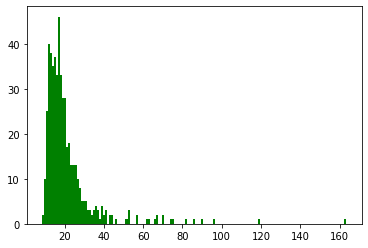

In [20]:
len_test_inp = [len(inp) for inp in test_inp]
len_test_inp = Counter(len_test_inp)
plt.bar(len_test_inp.keys(), len_test_inp.values(), width=1, color='g')

<BarContainer object of 6 artists>

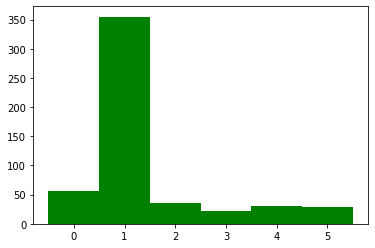

In [21]:
test_label = np.argmax(test_out, axis=1)
len_test_label = Counter(test_label)
plt.bar(len_test_label.keys(), len_test_label.values(), width=1, color='g')

# Create dataset

In [22]:
max_len = 30

train_inp = pad_sequences(train_inp, maxlen=max_len, value=1, padding='post')
dev_inp = pad_sequences(dev_inp, maxlen=max_len, value=1, padding='post')
test_inp = pad_sequences(test_inp, maxlen=max_len, value=1, padding='post')

In [23]:
train_attention_mask = np.where(train_inp == 1, 0, 1)
dev_attention_mask = np.where(dev_inp == 1, 0, 1)
test_attention_mask = np.where(test_inp == 1, 0, 1)

In [24]:
train_tokens = [inp if len(inp) < max_len else inp[0:max_len] for inp in train_tokens]
dev_tokens = [inp if len(inp) < max_len else inp[0:max_len] for inp in dev_tokens]
test_tokens = [inp if len(inp) < max_len else inp[0:max_len] for inp in test_tokens]

In [25]:
train_tokens = pad_sequences(train_tokens, maxlen=max_len)
dev_tokens = pad_sequences(dev_tokens, maxlen=max_len)
test_tokens = pad_sequences(test_tokens, maxlen=max_len)

# Define model

In [26]:
class BertModel(Model):
    def __init__(self, pretrained_model=phobert, hidden_dim=100, dropout_rate=0.5, output_dim=num_aspects):
        super().__init__(self)

        self.embedding = pretrained_model
        
        self.hidden = Dense(hidden_dim, activation='relu')
        self.dropout = Dropout(dropout_rate)

        self.dense = Dense(output_dim, activation='softmax')

    def call(self, inputs, attention_mask, training=True):
        x = inputs
        x = self.embedding(x, attention_mask)

        x = x['pooler_output']
        x = self.dropout(x, training=training)

        x = self.hidden(x, training=training)
        x = self.dense(x, training=training)

        return x

In [27]:
bert_model = BertModel()

# Hyperparameter

In [28]:
loss_function = CategoricalCrossentropy()
accuracy_function = Accuracy()

train_loss = Mean(name='train_loss')
dev_loss = Mean(name='dev_loss')
test_loss = Mean(name='test_loss')

In [29]:
learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)

In [30]:
EPOCHS = 15
ROUNDS = 3
BUFFER_SIZE = 1000
BATCH_SIZE = 128

In [31]:
checkpoint_path = "./bert_checkpoints/restaurant/"
ckpt = Checkpoint(bert_model, optimizer=optimizer)
ckpt_manager = CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

In [32]:
@tf.function
def train_step(inp, out, mask):
    with tf.GradientTape() as tape:
        pred = bert_model(inp, mask, True)

        loss = loss_function(out, pred)
    
    gradients = tape.gradient(loss, bert_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bert_model.trainable_variables))

    train_loss(loss)

# Training

In [33]:
def teacher(round, train_inp, train_tokens, train_attention_mask, dev_inp, dev_tokens, dev_attention_mask, dev_out, seed_set):
    print('TEACHER:')
    
    weight_seed = {}

    if round == 0:
        weight_seed = default_weight_seed
    else:
        train_size = train_inp.shape[0]
        student_train_pred = []

        for i in range(0, train_size, BATCH_SIZE):
            first = i
            last = min(i + BATCH_SIZE, train_size)

            # train_tmp = train_inp[first:last], (BATCH_SIZE, train_inp.shape[1]))
            # tmp_mask = train_attention_mask[first:last], (BATCH_SIZE, train_attention_mask.shape[1]))
            
            train_tmp = train_inp[first:last]
            tmp_mask = train_attention_mask[first:last]

            inp = tf.constant(train_tmp)
            mask = tf.constant(tmp_mask)
            preds = bert_model(inp, mask)
            preds = tf.argmax(preds, axis=1)
     
            for pred in preds:
                student_train_pred.append(pred.numpy())
        
        weight_seed = get_weight_seed(train_tokens, student_train_pred, seed_set)
    
    dev_pred = get_train_weak_out(dev_tokens, seed_set, weight_seed)
    
    dev_f1 = f1_score(tf.argmax(dev_out, axis=1), tf.argmax(dev_pred, axis=1), average='macro')

    print(f'Dev F1 Score: {dev_f1:.4f}')
    print()

    return weight_seed

In [34]:
def student(num_epochs, train_inp, train_tokens, train_attention_mask, dev_inp, dev_attention_mask, dev_out, seed_set, weight_seed):
    print('STUDENT:')
    
    train_out = get_train_weak_out(train_tokens, seed_set, weight_seed)

    train_examples = Dataset.from_tensor_slices((train_inp, train_out, train_attention_mask))

    train_batches = train_examples.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    best_epoch = 0
    best_dev_f1 = 0

    for epoch in range(num_epochs):
        start = time.time()

        train_loss.reset_states()

        for (batch, (inp, out, mask)) in enumerate(train_batches):
            train_step(inp, out, mask)
            if batch % 100 == 0:
                print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f}')

        dev_loss.reset_states()

        dev_inp_tensor = tf.constant(dev_inp)
        dev_out_tensor = tf.constant(dev_out)
        dev_attention_mask_tensor = tf.constant(dev_attention_mask)

        dev_pred = bert_model(dev_inp_tensor, dev_attention_mask_tensor, True)
        loss = loss_function(dev_out_tensor, dev_pred)
        dev_f1 = f1_score(tf.argmax(dev_out_tensor, axis=1), tf.argmax(dev_pred, axis=1), average='macro')

        if dev_f1 > best_dev_f1:
            best_dev_f1 = dev_f1
            best_epoch = epoch
        
        dev_loss(loss)

        if (epoch + 1) % 1 == 0:
            ckpt_save_path = ckpt_manager.save()
            print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
        
        print(f'Epoch {epoch + 1}: Loss {train_loss.result():.4f}')
    
        print(f'Dev loss: {dev_loss.result():.4f} Dev F1 Score: {dev_f1:.4f}')
    
        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

    return best_epoch


In [35]:
epoch = 0

In [36]:
for round in range(ROUNDS):

    print(f'ROUND {round + 1}:')
    
    # TEACHER
    weight_seed = teacher(round, train_inp, train_tokens, train_attention_mask, dev_inp, dev_tokens, dev_attention_mask, dev_out, seed_set)
        
    # STUDENT
    best_epoch = student(EPOCHS, train_inp, train_tokens, train_attention_mask, dev_inp, dev_attention_mask, dev_out, seed_set, weight_seed) + 1
    epoch = epoch + best_epoch

    print(f'Best epoch: {epoch}')
    ckpt.restore(checkpoint_path + 'ckpt-' + str(epoch))
    print(f'Restore from epoch {epoch}\n')

    teacher_test_pred = get_train_weak_out(test_tokens, seed_set, weight_seed)
    teacher_f1 = f1_score(tf.argmax(test_out, axis=1), tf.argmax(teacher_test_pred, axis=1), average='macro')

    print('TEACHER:')
    print(f'Test F1 Score: {teacher_f1:.4f}\n')


    test_inp_tensor = tf.constant(test_inp)
    test_out_tensor = tf.constant(test_out)
    test_attention_mask_tensor = tf.constant(test_attention_mask)
    student_test_pred = bert_model(test_inp_tensor, test_attention_mask_tensor, True)
    student_f1 = f1_score(tf.argmax(test_out_tensor, axis=1), tf.argmax(student_test_pred, axis=1), average='macro')
    clfrpt = classification_report(tf.argmax(test_out_tensor, axis=1), tf.argmax(student_test_pred, axis=1))

    print('STUDENT:')
    print(f'Test F1 Score: {student_f1:.4f}\n')
    print(clfrpt)


ROUND 1:
TEACHER:
Dev F1 Score: 0.7688

STUDENT:
Epoch 1 Batch 0 Loss 1.9178
Epoch 1 Batch 100 Loss 1.4987
Epoch 1 Batch 200 Loss 1.4200
Saving checkpoint for epoch 1 at ./bert_checkpoints/restaurant/ckpt-1
Epoch 1: Loss 1.4025
Dev loss: 1.5117 Dev F1 Score: 0.6858
Time taken for 1 epoch: 192.41 secs

Epoch 2 Batch 0 Loss 1.2291
Epoch 2 Batch 100 Loss 1.2371
Epoch 2 Batch 200 Loss 1.2471
Saving checkpoint for epoch 2 at ./bert_checkpoints/restaurant/ckpt-2
Epoch 2: Loss 1.2508
Dev loss: 1.4845 Dev F1 Score: 0.6626
Time taken for 1 epoch: 179.58 secs

Epoch 3 Batch 0 Loss 1.1530
Epoch 3 Batch 100 Loss 1.2156
Epoch 3 Batch 200 Loss 1.2328
Saving checkpoint for epoch 3 at ./bert_checkpoints/restaurant/ckpt-3
Epoch 3: Loss 1.2375
Dev loss: 1.3555 Dev F1 Score: 0.6734
Time taken for 1 epoch: 184.59 secs

Epoch 4 Batch 0 Loss 1.1791
Epoch 4 Batch 100 Loss 1.2031
Epoch 4 Batch 200 Loss 1.2211
Saving checkpoint for epoch 4 at ./bert_checkpoints/restaurant/ckpt-4
Epoch 4: Loss 1.2252
Dev loss: 